# Prediksi Cuaca

# Load & Preprocess Data

## Import Lib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

## Load Datasheet

In [2]:
data = pd.read_csv("datasetCuaca.csv") 

## Pilih fitur inputna

In [3]:
features = ["Temperature (C)", "Apparent Temperature (C)", "Humidity"]

In [4]:
data = data.dropna(subset=features)
if data[features].isna().sum().sum() == 0:
    print("Tidak ada nilai NaN dalam fitur yang dipilih.")
else:
    print("Terdapat nilai NaN dalam fitur yang dipilih.")

Tidak ada nilai NaN dalam fitur yang dipilih.


In [5]:
# Normalisasi data fitur
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

In [ ]:
data = data[data["Precip Type"].isin(["snow", "rain"])]
data["Precip Type"] = data["Precip Type"].astype("category")  # Konversi ke kategori
data["Precip Type"] = data["Precip Type"].cat.codes  # Ubah ke kode numerik
print(np.unique(data["Precip Type"])) 

[0 1]


In [7]:
num_classes = len(np.unique(data["Precip Type"]))  # Harusnya 2
y_labels = to_categorical(data["Precip Type"], num_classes=num_classes)

Membentuk Data Sequence untuk LSTM

In [8]:
def create_sequences(data, target, sequence_length=10):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(data[features].values, y_labels, sequence_length)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model LSTM

In [10]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, len(features))),
    Dropout(0.5),
    LSTM(32),
    Dense(16, activation="relu"),
    Dense(y.shape[1], activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


c:\Users\Wildanu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
history = model.fit(
    X_train, y_train, 
    epochs=20, batch_size=32, 
    validation_data=(X_test, y_test)
)

Epoch 1/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 0.9314 - loss: 0.1706 - val_accuracy: 0.9700 - val_loss: 0.0741
Epoch 2/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9625 - loss: 0.0884 - val_accuracy: 0.9763 - val_loss: 0.0608
Epoch 3/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9707 - loss: 0.0727 - val_accuracy: 0.9729 - val_loss: 0.0674
Epoch 4/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.9733 - loss: 0.0672 - val_accuracy: 0.9753 - val_loss: 0.0603
Epoch 5/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.9741 - loss: 0.0688 - val_accuracy: 0.9794 - val_loss: 0.0538
Epoch 6/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.9751 - loss: 0.0639 - val_accuracy: 0.9787 - val_loss: 0.0557
Epoch 7/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.9756 - loss: 0.0620 - val_accuracy: 0.9774 - val_loss: 0.0546
Epoch 8/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.9760 - lo

In [12]:
model.save("model_cuaca.h5")

In [13]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Akurasi Model: {acc:.2%}")

600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9742 - loss: 0.0691
Akurasi Model: 97.45%


In [14]:
predicted_weather = model.predict(X_test[-1].reshape(1, sequence_length, len(features)))
print("Probabilitas Prediksi:", predicted_weather)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
Probabilitas Prediksi: [[0.01323704 0.98676294]]


In [15]:
print(np.unique(data["Precip Type"]))

[0 1]


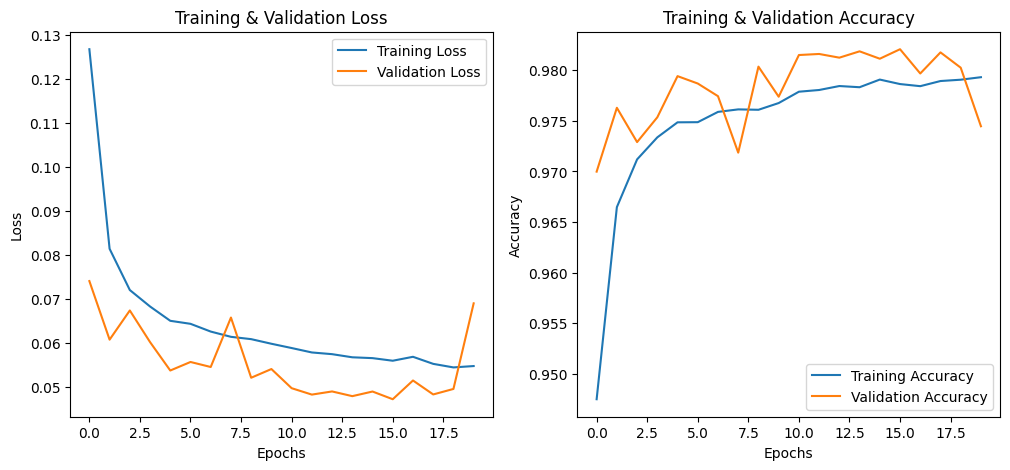

In [16]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")

# Plot Akurasi
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")

plt.show()